In [1]:
import importlib, yaml
import os, pandas as pd, numpy as np
from joblib import dump, load
import matplotlib.pyplot as plt
from contextlib import contextmanager
from collections import defaultdict
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
import sod.core.dataset as sod_core_dataset
importlib.reload(sod_core_dataset)
import sod.core.plot as sod_plot
importlib.reload(sod_plot)
from sod.core import pdconcat
import sod.core.evaluation as sod_core_eval
importlib.reload(sod_core_eval)
from sklearn.metrics import roc_curve
from itertools import cycle
# from sod.core.dataset import open_dataset # , normalize_df
# from sod import plot

print('loading source testset')
allset_test = sod_core_dataset.open_dataset('allset_test.hdf', normalize=False, verbose=False)
print('Columns')
print(allset_test.columns.tolist())
print()
print('DONE')



loading source testset
Columns
['allset_test.id', 'dataset_id', 'psd@0.05sec', 'psd@0.1sec', 'psd@0.2sec', 'psd@0.5sec', 'psd@1sec', 'psd@2sec', 'psd@3sec', 'psd@5sec', 'psd@9sec', 'outlier', 'subclass', 'window_type', 'amplitude_ratio', 'event_id', 'station_id', 'event_time', 'channel_code', 'magnitude', 'distance_km', 'location_code']

DONE


In [13]:
# Reading (creating) predictions on the test set instances

maindir = os.path.abspath(os.path.join(os.getcwd(), '..', 'evaluations/results/eval.allset_train_test.iforest.yaml/'))
assert os.path.isdir(maindir)

# classifier names
names = [
    # 'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=200',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=200',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=200',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=200',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=100',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=50',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=50',
#     'IsolationForest?features=psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=200',
#     'IsolationForest?features=psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=200',
#     'IsolationForest?features=psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=200',
#     'IsolationForest?features=psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100',
#     'IsolationForest?features=psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100',
#     'IsolationForest?features=psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=100',
#     'IsolationForest?features=psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=50',
#     'IsolationForest?features=psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50',
#     'IsolationForest?features=psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=50',
]
# check we did provide different file names:
assert len(set(names)) == len(names)


print('Reading the following classifiers (clf) with relative id (id: clf name):')
for i, n in enumerate(names):
    print('[%d]: %s' % (i, n))
clfs = [load(os.path.join(maindir, 'models', name+'.model')) for name in names]

print('Loading prediction dataframes')
maindir_preddf = os.path.abspath(os.path.join(os.getcwd(), '..', 'evaluations/results/clfeval.allset_train_test.iforest.psd@5sec.yaml/'))
assert os.path.isdir(maindir_preddf)
pred_dfs = [
    pd.read_hdf(os.path.join(_, 'predictions', name+'&testset=allset_test.hdf'))
    for _,name in zip(cycle([maindir_preddf]), names)
]

classnames = sod_core_dataset.allset_test.classnames
classes = {_: sod_core_dataset.allset_test.class_selector[_] for _ in classnames}
assert len(classes) == 3

def get_pred_df(index, *classindices):
    # label can be either 0: validation set inliers, 1: validation set outliers, 2: test set
    _df_ = pred_dfs[index]
    if not classindices:
        return _df_
    selector = None
    for classindex in classindices:
        _selector = classes[classnames[classindex]](_df_)
        if selector is None:
            selector = _selector
        else:
            selector |= _selector 
    return _df_[selector] 


print('Setting scores with offset and normalization (columns score_samples_offset_only and score_samples)')

best_thresholds, maxima = [] , []
# setting stuff:
for idx, pred_df in enumerate(pred_dfs):
    pred_df['channel_code'] = pred_df['channel_code'].astype('category')
    pred_df['location_code'] = pred_df['location_code'].astype('category')
    pred_df['cha_id'] = pred_df['channel_code'].str[:2]
    pred_df['cha_id'] = pred_df['cha_id'].astype('category')
    
    # get best threhold, calcuated from validation set only (inliers + outliers, no Me unknown):
    pred_df_outl_inl_only = get_pred_df(idx, 0, 1)
    fpr, tpr, th = roc_curve(pred_df_outl_inl_only.outlier, pred_df_outl_inl_only.predicted_anomaly_score)
    argmax = np.argmax((1-fpr[1:])*tpr[1:])
    best_th = th[1:][argmax]
    
    scores = np.copy(pred_df.predicted_anomaly_score.values)
    
    # offset: ====================
    scores += 0.5 - best_th
    # ============================
    pred_df['score_samples_offset_only'] = np.copy(scores)
    
    # adjust: ====================
    _max = np.nanmax(scores)
    scores = 0.5 + 0.5*((scores -0.5) / (_max - 0.5))
    # ============================
    pred_df['score_samples'] = scores
    
    best_thresholds.append(best_th)
    maxima.append(_max)


print('Thresholds')
for i, th in enumerate(best_thresholds):
    print('[%i]: %f' % (i, th))


# define the scores function
def score_samples(clf_index, psds, offset=True, normalize=True):
    clf = clfs[clf_index]
    
    scores = -clf.score_samples(psds.reshape((len(psds), 1)))
    if offset:
        scores += 0.5 - best_thresholds[clf_index]
    if normalize:
        _max = maxima[clf_index]
        scores = 0.5 + 0.5*((scores -0.5) / (_max - 0.5))
    return scores

print('Prediction dataframe  (testsets and valsets) columns:')
print(pred_df.columns.tolist())
print('DONE')

Reading the following classifiers (clf) with relative id (id: clf name):
[0]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=200
[1]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=200
[2]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=200
[3]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100
[4]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100
[5]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=100
[6]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=50
[7]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50
[8]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=

In [14]:
bins = np.arange(-200, 100, 0.1)
print('Comparing models (clfs) scores:')
print('Above main diagonal: maxima, below main diagonal: median')
indices = list(range(len(clfs)))
dfr = pd.DataFrame(index=indices, columns=indices, data=np.nan)
for i in indices:
    clf1 = i
    for j in indices:
        if i >= j:
            continue
        clf2 = j
        scores1 = score_samples(i, bins, False, False)
        scores2 = score_samples(j, bins, False, False)
        _diffs = np.abs(np.diff(np.array([scores1, scores2]), axis=0))[0]
        dfr.at[i, j] = np.round(np.max(_diffs),2)
        dfr.at[j, i] = np.round(np.median(_diffs),2)

print(dfr.to_string())
print('DONE')

Comparing models (clfs) scores:
Above main diagonal: maxima, below main diagonal: median
      0     1     2     3     4     5     6     7     8
0   NaN  0.07  0.11  0.02  0.07  0.12  0.02  0.07  0.13
1  0.03   NaN  0.07  0.08  0.02  0.07  0.08  0.02  0.08
2  0.03  0.01   NaN  0.12  0.07  0.03  0.11  0.08  0.04
3  0.01  0.03  0.04   NaN  0.07  0.11  0.02  0.08  0.12
4  0.02  0.01  0.01  0.02   NaN  0.07  0.07  0.02  0.08
5  0.02  0.01  0.01  0.02  0.01   NaN  0.11  0.09  0.02
6  0.01  0.04  0.04  0.01  0.03  0.03   NaN  0.07  0.12
7  0.03  0.00  0.01  0.03  0.01  0.01  0.04   NaN  0.10
8  0.01  0.01  0.01  0.02  0.01  0.00  0.03  0.01   NaN
DONE



Plotting classifiers by n_estimators


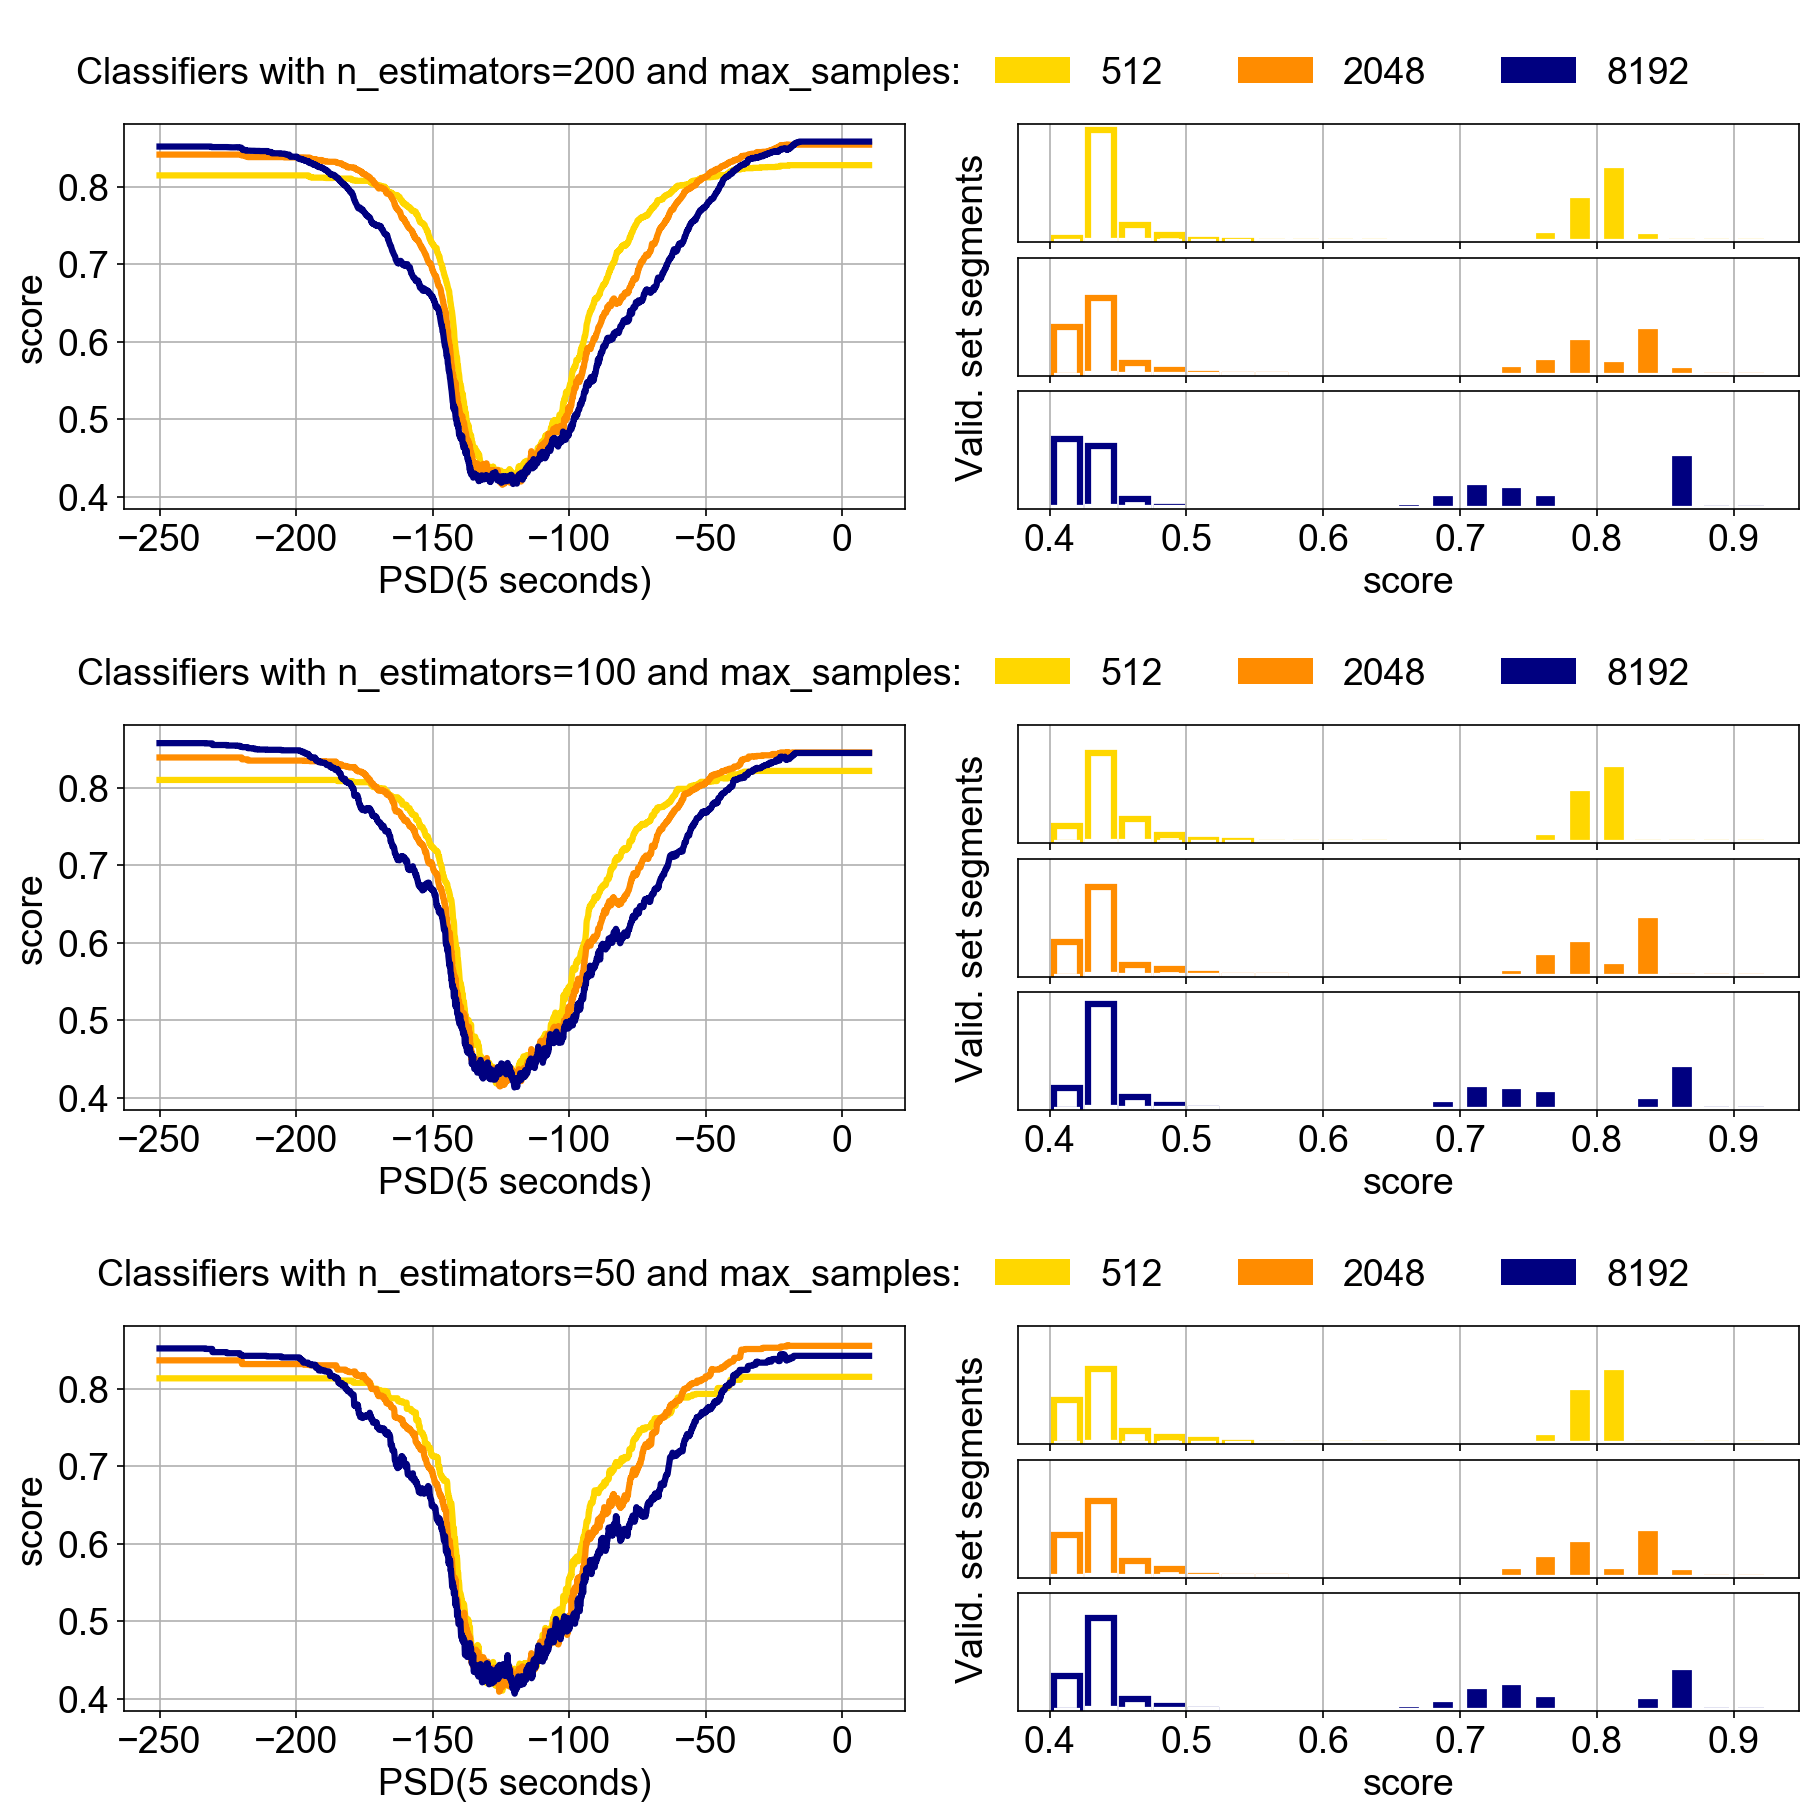

In [12]:
# now plot classifiers:
@contextmanager
def plotparams(params):
    '''makes temporarily matplotlib params.
    Make sure to run this after %matplotlib inline.
    For info see https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger'''
    def_params = {k: plt.rcParams[k] for k in params}
    for k, v in params.items():
        plt.rcParams[k] = v
    try:
        yield
    finally:
        for k, v in def_params.items():
            plt.rcParams[k] = v

bins_psd = np.arange(-250, 10, 0.1)
bins_scores = np.arange(0.4, 0.95, 0.025)
bins_score_ticks = bins_scores[::4]

colors = ['gold', 'darkorange', 'navy'] # 'mediumseagreen', 'navy']  # ['tab:olive', 'tab:blue', 'tab:orange']

data = [
    [clfs[i], score_samples(i, bins_psd, False, False),
     get_pred_df(i, 0).predicted_anomaly_score.values,  # inliers
     get_pred_df(i, 1).predicted_anomaly_score.values,  # outliers
    ] for i in range(len(clfs))
]


ticks = [0, .25, .5, .75, 1]

def setlim(axes, x=True, y=True):
    minx, maxx, miny, maxy = np.inf, -np.inf, np.inf, -np.inf
    for ax in axes:
        minx = min(ax.get_xlim()[0], minx)
        maxx = max(ax.get_xlim()[1], maxx)
        miny = min(ax.get_ylim()[0], miny)
        maxy = max(ax.get_ylim()[1], maxy)
    for ax in axes:
        if x:
            ax.set_xlim(minx, maxx)
        if y:
            ax.set_ylim(miny, maxy)
    if x and y:
        return minx, maxx, miny, maxy
    elif x:
        return minx, maxx
    elif y:
        return miny, maxy
    else:
        raise ValueError('x and y can not be both False')

print()
print('Plotting classifiers by n_estimators')
with plotparams({'figure.figsize': (12, 12), 'font.size': 18, 'figure.dpi': 150, 'font.family': 'helvetica,arial'}):
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(12, 3, height_ratios=[1,2,2,2,1,2,2,2,1,2,2,2], width_ratios=[50, 1, 50])
    
    # fig, axs = plt.subplots(3, 2)

    for i in range(3):
        data_slice = data[i*3: (i+1)*3]
        titles = set([d[0].n_estimators for d in data_slice])
        assert len(titles) == 1
        ax = fig.add_subplot(gs[i*4, :])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        # comment this if you want to place title and legend:
        ax.axis('off')
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.text(0.5, 0, 'Classifiers with n_estimators=%d and max_samples:' % list(titles)[0],
                ha='right', va='center')
        for d, color in zip(data_slice, colors):
            ax.bar([0],[0], color=color, label=str(d[0].max_samples))
        # place legend: A 2-tuple (x, y) places the corner of the legend specified by `loc` at x, y:
        ax.legend(loc='center left', ncol=6, bbox_to_anchor=(.5, 0), frameon=False)
        # ax.set_title('Classifiers with n_estimators=%d' % list(titles)[0], loc='center')
        
    # left side axes (scores)
    axs_ = []
    for i in range(3):
        ax = fig.add_subplot(gs[(i*4)+1:(i*4)+4, 0])
        axs_.append(ax)
        data_slice = data[i*3: (i+1)*3]
        for d, color in zip(data_slice, colors):
            ax.plot(bins_psd, d[1], label='max_samples: %d' % d[0].max_samples, linewidth=3, color=color)
        ax.set_xlabel('PSD(5 seconds)')
        ax.set_ylabel('score')
        # ax.legend()
        ax.grid()
    setlim(axs_, x=True, y=True)
    
    for i in range(3):
        ax = fig.add_subplot(gs[(i*4)+1:(i*4)+4, 1])
        ax.set_ylabel('Valid. set segments')
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_ticklabels([])
        ax.get_yaxis().set_ticks([])
        ax.yaxis.set_label_position("right")

    axs_ = []
    for i in range(3):
        data_slice = data[i*3: (i+1)*3]
        # testset_scores = [d[2] for d in data_slice]
        clf_labels = ['max_samples: %d' % d[0].max_samples for d in data_slice]
        for j, color in zip(range(3), colors):
            ax = fig.add_subplot(gs[(i*4)+1+j, 2])
            axs_.append(ax)
            testset_inliers_scores = data_slice[j][2]
            testset_outliers_scores = data_slice[j][3]
            ax.hist(testset_inliers_scores,
                    bins=bins_scores, label=clf_labels[j],
                    stacked=False,
                    histtype='bar', linewidth=3, align='mid'
                    , rwidth=0.75, color='white', edgecolor=color,
                   )
            ax.hist(testset_outliers_scores,
                    bins=bins_scores, label=clf_labels[j],
                    stacked=False,
                    histtype='bar', linewidth=3, align='mid'
                    , rwidth=0.75, color=color, edgecolor='white',
                   )
            # ax.set_ylabel('test set segments')
            # ax.set_xlabel('score')
            ax.set_xticks(bins_score_ticks)
            if j < 2:
                ax.get_xaxis().set_ticklabels([])
            else:
                ax.set_xlabel('score')
            ax.get_yaxis().set_visible(False)
            # ax.legend()
            ax.grid()
    setlim(axs_, x=True, y=True)

    # plt.tight_layout()
    plt.show()

In [15]:
# plotting misclassified channels
import csv

print('Adding event time to prediction dataframes')
timin, tmax = None, None
for i, pred_df in enumerate(pred_dfs):
    assert 'event_time' not in pred_df.columns
    _pred_df = pred_df.merge(allset_test[['allset_test.id', 'dataset_id', 'event_time']],
                             how='left', on=['allset_test.id', 'dataset_id'])
    assert 'event_time' in _pred_df.columns
    natimes = pd.isna(_pred_df.event_time).sum()
    if natimes:
        raise ValueError('%d NAT' % natimes)
    _pred_df = _pred_df.dropna(subset=['event_time'])
    pred_dfs[i] = _pred_df.copy()

    _tmin, _tmax = pd.to_datetime(_pred_df.event_time.min()), pd.to_datetime(_pred_df.event_time.max())
    if i == 0 or _tmin < tmin:
        tmin = _tmin
    if i==0 or _tmax > tmax:
        tmax = _tmax

print('Event times (min, max): %s, %s' % (str(tmin), str(tmax)))

print('Getting station networks and stations (querying source databases)')
_fle = os.path.abspath(os.path.join('.', 'jnconfig.yaml'))
assert os.path.isfile(_fle)
with open(_fle, "r") as _:
    jnconfig = yaml.safe_load(_)

dataset_urls= {
    1: jnconfig['dbpath_new'],
    2: jnconfig['dbpath_me'],
    3: jnconfig['dbpath_chile']
}


station_codes = {}

from stream2segment.process.db import get_session
from stream2segment.io.db.models import Station, Segment, concat, Channel
from stream2segment.io.utils import loads_inv

for dts_id, df in pred_dfs[0].groupby('dataset_id'):  # use just one prediction dataframe, the first
    sess = get_session(dataset_urls[dts_id])
    for (staid, stanet, stasta) in sess.query(Station.id, Station.network, Station.station):
        station_codes[(dts_id, staid)] = "%s.%s" % (stanet, stasta)
    sess.close()


print('DONE')

Adding event time to prediction dataframes
Event times (min, max): 1999-07-07 17:16:11, 2019-08-29 15:07:59
Getting station networks and stations (querying source databases)


/Users/riccardo/work/gfz/projects/sources/python/sod/.env/sod/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


DONE


In [21]:
print('Creating dictionaries of predictions on a per station basis with prediction scores mapped to event times')
columns = ['dataset_id', 'station_id', 'cha_id', 'location_code']

data_predicted = {}
from collections import defaultdict

for iii in range(len(clfs)):
    pred_df = get_pred_df(iii, 2)
    for (dts_id, sta_id, cha_id, loc_code), df in pred_df.groupby(columns):

        channel = '%s.%s.%s?' % (station_codes[(dts_id, sta_id)], loc_code, cha_id)
        key = (int(sta_id), int(dts_id), channel)

        if key in data_predicted:
            _plot = data_predicted[key]
        else:
            _plot = {
                'channel': channel,
                'num_segments': len(df),
                'dataset_name': dataset_urls[dts_id][dataset_urls[dts_id].rfind('/')+1:],
                'dataset_id': dts_id,
                'station_id': sta_id,
                'scores': [None for _ in names]
            }
            data_predicted[key] = _plot

        _plot['scores'][iii] = df[['event_time', 'score_samples']]

print('DONE')

Creating dictionaries of predictions on a per station basis with prediction scores mapped to event times


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Comparing with annotated labels
Using only labels: ['unlabeled (Me unknown)']
Minima scores (used for MSE)
CLF [0]: 0.249537
CLF [1]: 0.350232
CLF [2]: 0.395220
CLF [3]: 0.210442
CLF [4]: 0.332357
CLF [5]: 0.370538
CLF [6]: 0.192136
CLF [7]: 0.317891
CLF [8]: 0.349584
comparing prediction with labels
Parsing error in date or scores or ids: Skipping station_id=2732 (dataset_id=2), channel=JP.JWT..BH?
Parsing error in date or scores or ids: Skipping station_id=1337 (dataset_id=2), channel=ND.MARNC.00.BH?
Parsing error in date or scores or ids: Skipping station_id=372 (dataset_id=2), channel=KO.BAYT..BH?
Parsing error in date or scores or ids: Skipping station_id=3507 (dataset_id=2), channel=TM.PRAC..BH?
Parsing error in date or scores or ids: Skipping station_id=3500 (dataset_id=2), channel=TM.LOEI..BH?
Parsing error in date or scores or ids: Skipping station_id=3211 (dataset_id=2), channel=RV.HILA..BH?

CLF: [0] (max_samples=512, n_estimators=200): MSE: 0.071731
CLF: [1] (max_samples=20

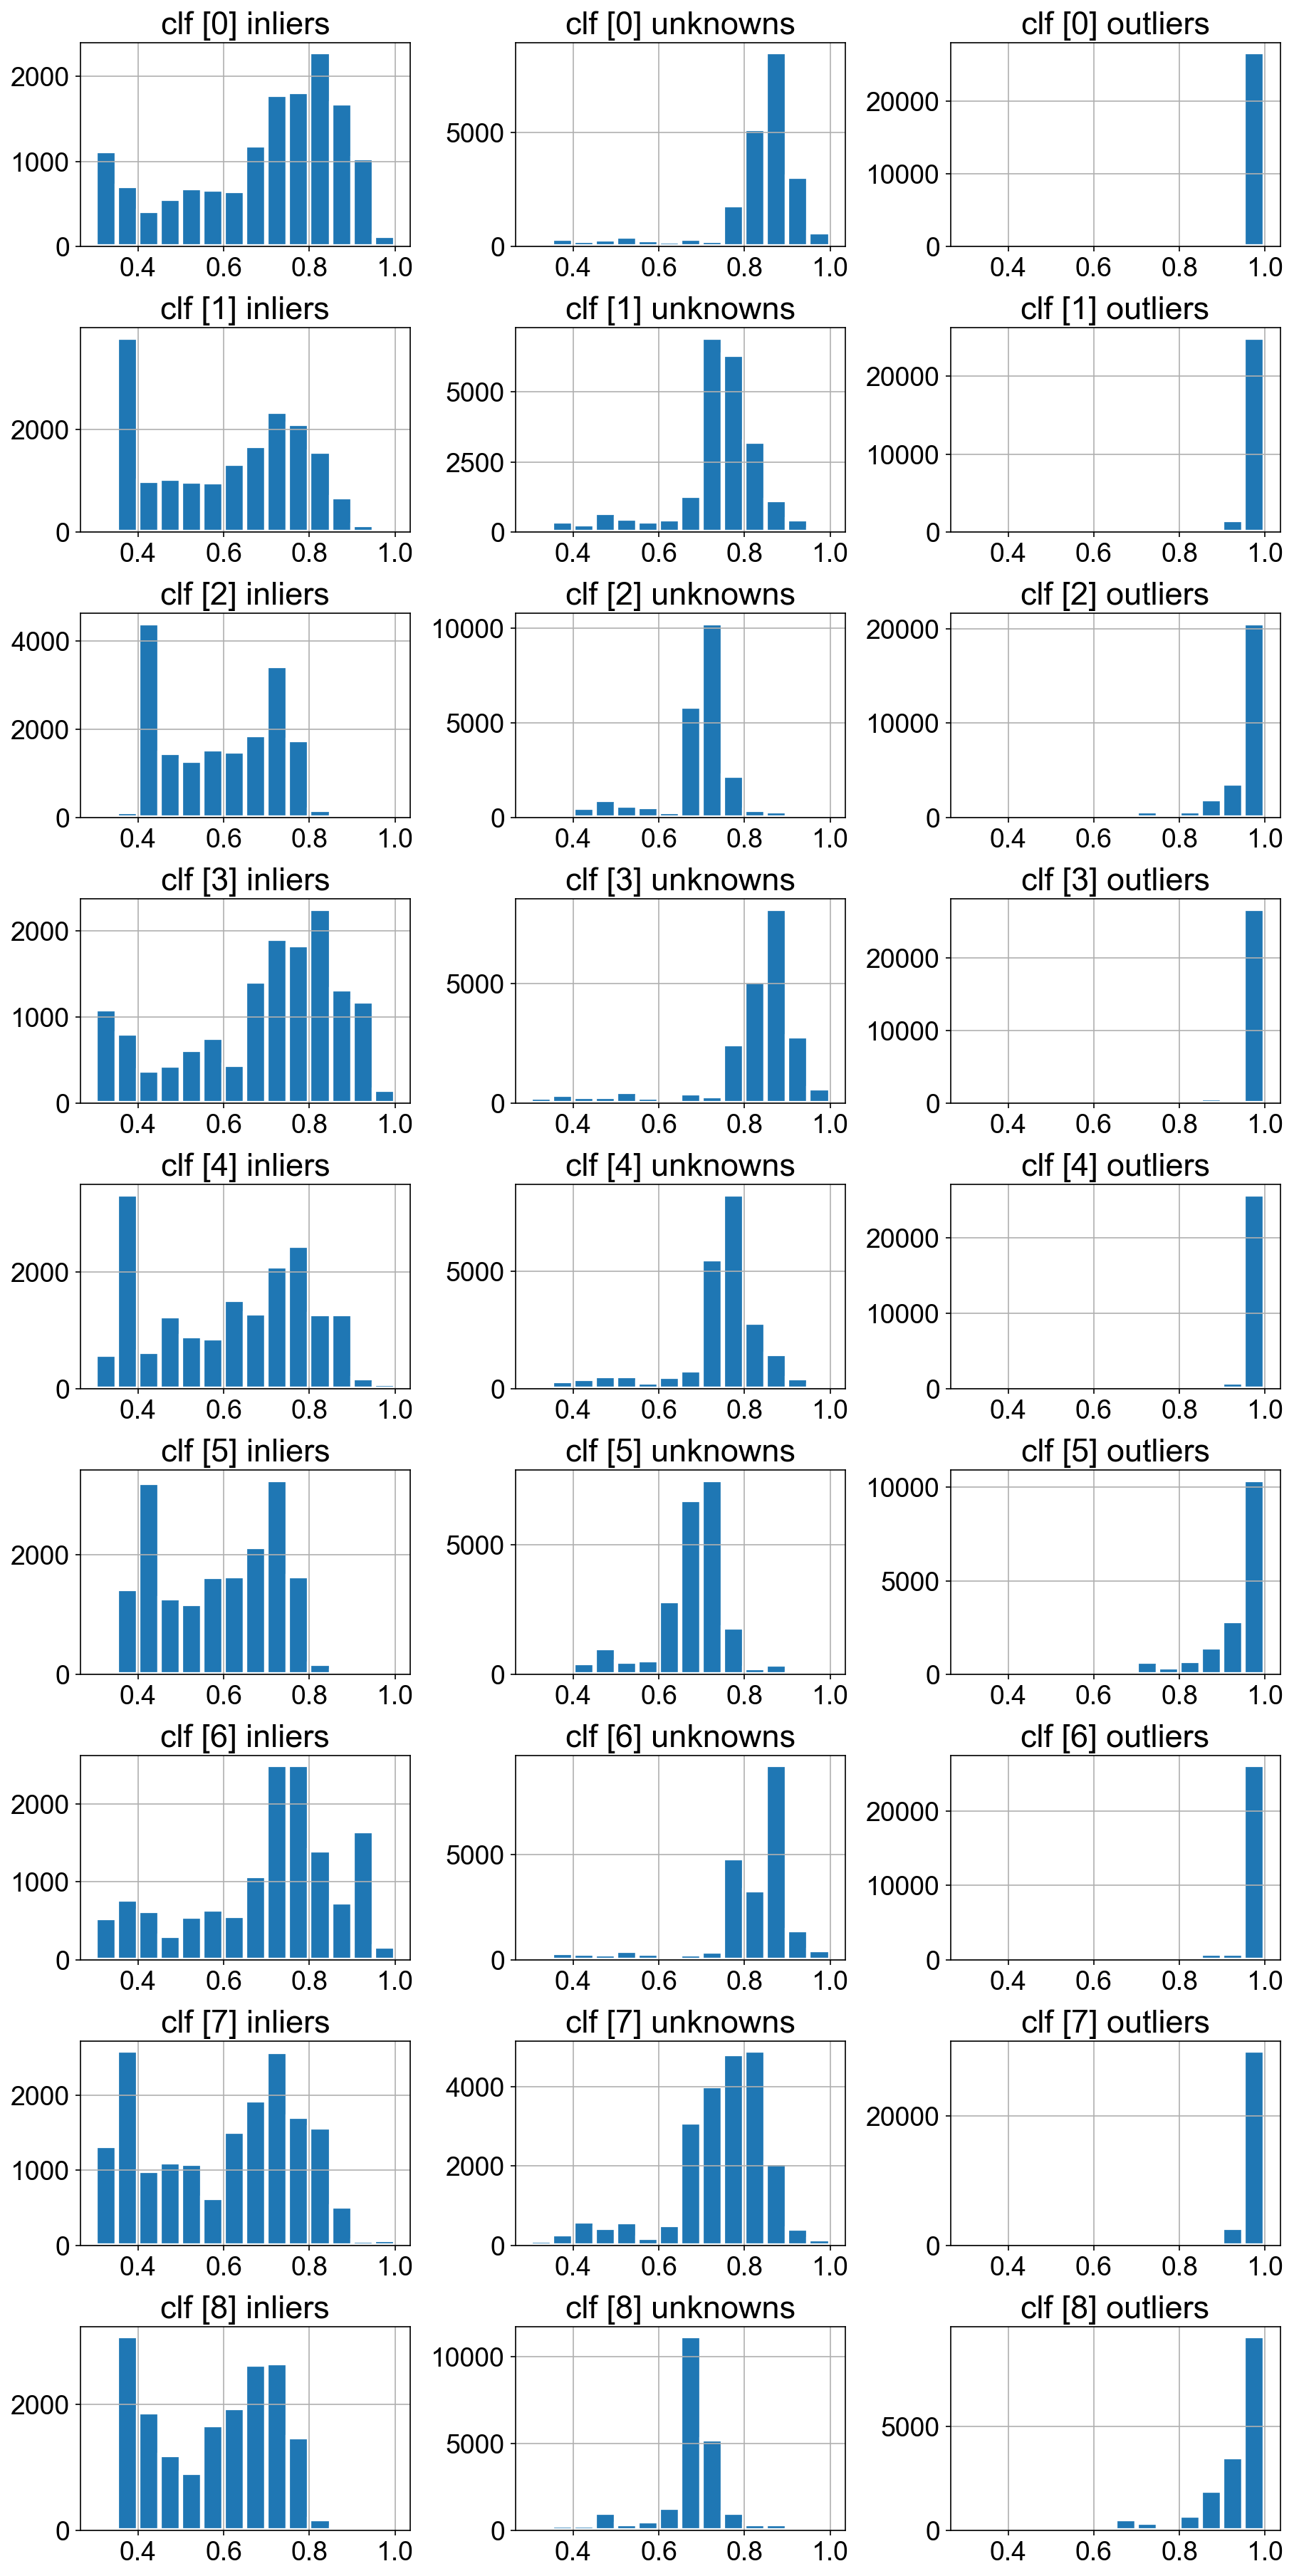

In [22]:
print('Comparing with annotated labels')
            
from datetime import datetime, timedelta
# datetime.strptime("2010-06-04 21:08:12", "%Y-%m-%d %H:%M:%S")
time0 = tmin - timedelta(days=1)
time1 = tmax + timedelta(days=1)
# time1 = datetime(year=2260, month=1, day=1)  # https://stackoverflow.com/a/37226672

# process only csv rows with this value of 'label':
labels = ['unlabeled (Me unknown)']
print('Using only labels: %s' % labels)

min_psd5scores = [np.nanmin(score_samples(i, np.arange(-150, -100, 0.01), True, True)) for i in range(len(clfs))]
print('Minima scores (used for MSE)')
for i in range(len(min_psd5scores)):
    print('CLF [%d]: %f' % (i, min_psd5scores[i]))


print('comparing prediction with labels')
from sklearn.metrics import mean_squared_error as MSE
# map each classifier index to the tuplke (sum_of_mse, number_of_instances)
# this is why MSE multuoutput 'raw_values' seems not to work (it returns the average. WHY???)
mean_squared_errors = [[0, 0] for _ in names]

csvpath = '/Users/riccardo/Nextcloud/rizac_docs/plot.misclassified.final.csv'

newscores = [[[], [], []] for _ in range(len(clfs))]

with open(csvpath, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row['label'] not in labels:
            continue
        try:
            id_ = (int(row['station_id']), int(row['dataset_id']), row['channel'])
            annotated_score = float(row['score_d'])
            start_time = time0 if not row['start_time'] else datetime.strptime(row['start_time'], "%Y-%m-%d")
            end_time = time1 if not row['end_time'] else datetime.strptime(row['end_time'], "%Y-%m-%d")            
        except ValueError:
            print('Parsing error in date or scores or ids: Skipping station_id=%s (dataset_id=%s), channel=%s' %
                  (row['station_id'], row['dataset_id'], row['channel']))
            continue

        # try to parse also second annotator:
        try:
            annotated_score = 0.5 * (annotated_score * float(row['score_a']))
        except (ValueError, TypeError):
            pass
        
        # fetch data predicted:
        data_pred = data_predicted[id_]
        # print(data_pred)
        zcores = data_pred['scores']
        for clf_idx, _df_ in enumerate(zcores):
            
            # create dataframe with times and predictions:
            _df_with_matching_events = _df_[(_df_.event_time > start_time) & (_df_.event_time < end_time)]
            y_pred = _df_with_matching_events['score_samples'].values
            y_true = np.ones(len(y_pred)) * annotated_score
            
            newscores[clf_idx][0].append(y_pred[y_true==0])
            newscores[clf_idx][1].append(y_pred[y_true==0.5])
            newscores[clf_idx][2].append(y_pred[y_true==1])
            
            y_true[y_true == 0] = min_psd5scores[clf_idx]
            # print(y_pred[:10])
            # print(y_true[:10])
            # print(clf_idx)
            mse = MSE(y_true, y_pred, multioutput='uniform_average')
            # print(mse)
            # print('F: %d, %s' % (clf_idx, str(mean_squared_errors[clf_idx])))
            mean_squared_errors[clf_idx][0] += mse * len(_df_)
            mean_squared_errors[clf_idx][1] += len(_df_)
            
            # print('\n%d' % clf_idx)
            # print(_df_[:5])
            
            
            # print(mean_squared_erros[clf_idx])
        # raise

print()
for i, mserr in enumerate(mean_squared_errors):
    total_mse = np.sum(mserr[0]) / np.sum(mserr[1])
    print('CLF: [%d] (max_samples=%d, n_estimators=%d): MSE: %f' %
          (i, clfs[i].max_samples, clfs[i].n_estimators, total_mse))
    
with plotparams({'figure.figsize': (12, 24), 'font.size': 18, 'figure.dpi': 150, 'font.family': 'helvetica,arial'}):
    bins = np.arange(0.3, 1.05, 0.05)
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(len(newscores), len(newscores[0]))  #, height_ratios=[1,2,2,2,1,2,2,2,1,2,2,2], width_ratios=[50, 1, 50])
    for i, clf_newscores in enumerate(newscores):
        for j, newscore in enumerate(clf_newscores):
            title = 'clf [%d]' % i
            ax = fig.add_subplot(gs[i, j])
            ax.hist(np.hstack(newscore), edgecolor='white', linewidth=3, bins=bins)
            if j == 0:
                title += ' inliers'
            elif j==1:
                title += ' unknowns'
            else:
                title += ' outliers'
            ax.set_title(title)
            ax.grid()
    plt.show()

In [19]:
np.hstack([[1,2, 5], [2,3], []])

array([ 1.,  2.,  5.,  2.,  3.])